# Quick example of Supervised
## with CE

This example tries to show the usage of the classes and methods
proposed here to show classification.

In this case we use the **CE** loss.

In [1]:
# Importing general libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np

# Importing specific classes and functions
from utils.weakener import Weakener

#Importing drawing tools
import matplotlib.pyplot as plt

#importing dataloaders
from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from models.model import MLP
from utils.trainig_testing import train_model,evaluate_model,train_and_evaluate
from utils.losses import EMLoss, CELoss

In [2]:
# DS stores the dataset and its related attributes
DS = Torch_Dataset('mnist')
train_x, train_y, test_x, test_y = DS.get_data()
# WL stores pocesses relative to the Weakening process
WL = Weakener(DS.num_classes)


In [3]:
# Generation of the mixing matrix according to the model
#  we've chosen.
WL.generate_M(model_class='supervised')
print(WL.M)
print(WL.labels)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
{0: '1000000000', 1: '0100000000', 2: '0010000000', 3: '0001000000', 4: '0000100000', 5: '0000010000', 6: '0000001000', 7: '0000000100', 8: '0000000010', 9: '0000000001'}


In [4]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
z, w = WL.generate_weak(train_y)

z is the numerical encodig of the weak label while w is a one-hot
representation of that variable. z also encodes the row of the M matrix
for that given weak label.

Let's consider the example of partial label learning for the iris dataset.
labels are encoded as ```{0: '011', 1: '101', 2: '110', 3: '111'}```
so having an isntance with `z=3` means `w=[1,1,1]`, i.e., the weak label contains every label.

In [5]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
WL.virtual_matrix(convex=True)
#And we generate the virtual labels
WL.virtual_labels(train_y)
WL.v[:10,:]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
#We need to include this Weak Labels into the dataset,
# we need to include w to mantain the coherence. z will only be used
# in the loss for the EM
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

print(len(testloader.dataset))
print(len(trainloader.dataset))

10000
60000


Now we have a trainloader containing (X,v,y) and a testloader containig (X,y)
so we can just establish our model and train it.



In [7]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[DS.num_features,DS.num_features,DS.num_features],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=40)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 10/40: Train Loss: 0.4993, Train Acc: 0.8891, Test Acc: 0.9465
Epoch 20/40: Train Loss: 0.5048, Train Acc: 0.8960, Test Acc: 0.9447
Epoch 30/40: Train Loss: 0.5214, Train Acc: 0.8920, Test Acc: 0.9398
Epoch 40/40: Train Loss: 0.5727, Train Acc: 0.8872, Test Acc: 0.9426
Train Loss: tensor(0.5727)
Train Accuracy: tensor(0.8872)
Test Accuracy: tensor(0.9426)


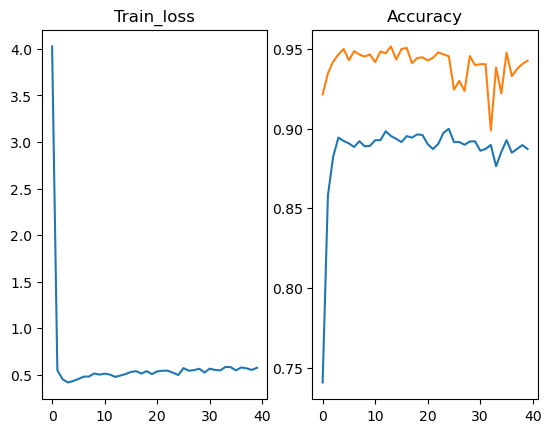

In [8]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()